# Using D-FINE, a SoTA object detection model to train a given image dataset
## Actual Problem Statement: Cleaning a Contaminated Image Classification Dataset Using Object Detection

In [67]:
import pandas as pd
import numpy as np
import os
import glob
import shutil
from pathlib import Path

In [68]:
"""
    1. Original (Contaminated) Folder:
        - bg_dir (str): folder containing background images
        - fb_dir (str): folder containing football images
    2. All image file names(titles):
        - bg_file_names (list): contains the actual file titles/names for background images
        - fb_file_names (list): contains the actual file titles/names for football images
"""
bg_dir = './contaminated_classifier_data/background'
fb_dir = './contaminated_classifier_data/football'

bg_file_names = []
fb_file_names = []

def extract_file_names(dir_loc):
    """
    Extracts the file titles for all the files in a directory
    
    Args:
        dir_loc (str): directory path

    Returns:
        file_names (list): list of all the file names
    """
    if dir_loc is None:
        return []
    
    file_names_ls = []
    
    # i'm assuming we only have jpg files
    file_names_ls = glob.glob(os.path.join(dir_loc, '*'))
    return file_names_ls
    
bg_file_names = extract_file_names(bg_dir)
fb_file_names = extract_file_names(fb_dir)

### checking number of images per folder

In [69]:
jpg_bg_files = [file for file in bg_file_names if file.endswith('.jpg')]
jpg_fb_files = [file for file in fb_file_names if file.endswith('.jpg')]

print(f"Number of background images: {len(bg_file_names)}")
print(f"Number of .jpg files in {bg_dir} diretory: {len(jpg_bg_files)}")
print()
print(f"Number of football images: {len(fb_file_names)}")
print(f"Number of .jpg files in {fb_dir} diretory: {len(jpg_fb_files)}")

Number of background images: 4549
Number of .jpg files in ./contaminated_classifier_data/background diretory: 4549

Number of football images: 4050
Number of .jpg files in ./contaminated_classifier_data/football diretory: 4050


### manually observing images

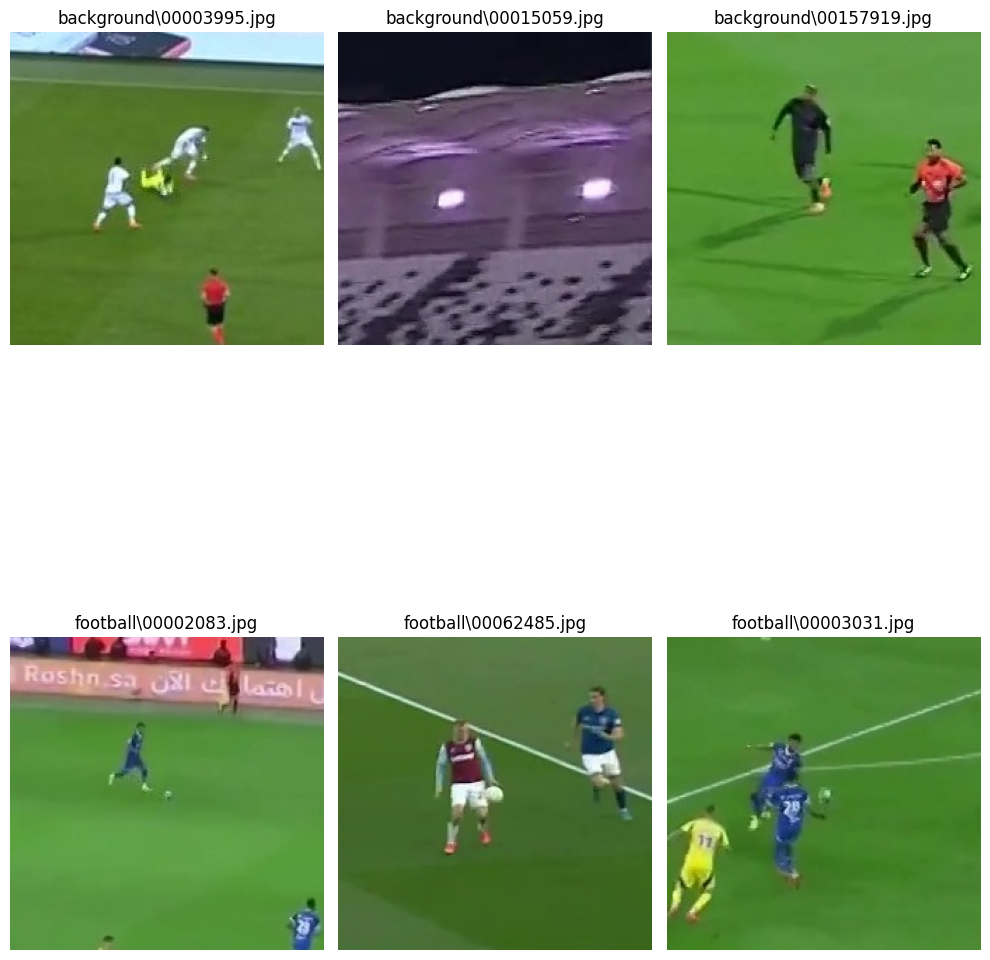

In [70]:
# Display 3 random images each from the contaminated folder

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def display_images(num_rows, num_cols, image_paths):
    """
    Display a grid of (num_rows*num_cols) images

    Args:
        num_rows (int): number of rows
        num_cols (int): number of images per row
        image_paths (list): list(s) of image paths
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_rows, 5*num_cols)) # produce a 5 * 5 image
    
    for i in range(num_rows):
        for ax, img_path in zip(axes[i], image_paths[i]):
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(img_path.split('/')[-1])
        
        
num_bg_images = len(bg_file_names)
num_fb_images = len(fb_file_names)

bg_images_temp = [bg_file_names[random.randint(0, num_bg_images-1)] for i in range(3)]
fb_images_temp = [fb_file_names[random.randint(0, num_fb_images-1)] for i in range(3)]

display_images(2, 3, [bg_images_temp, fb_images_temp])

plt.tight_layout()
plt.show()

#### From manually observing 10 sets of 3 random images, I found that around 1/5th of the background images contain footballs.
***While this has no direct implications, I can rest assured that quite a few of the images have been incorrectly labelled.***

In [71]:
from src.infer.torch_model import Torch_model
import torch
from torch.utils.data import Dataset, DataLoader

custom_pretrained_model_path = "./custom_pretrained_model/model.pt"

IMG_W = 640
IMG_H = 640
CONF_THRESH = 0.6 # i'm setting the threshold to 0.6 because the training logs mention that the best threshold was 0.6
BATCH_SIZE = 4

def load_model(IMG_W, IMG_H, CONF_THRESH, model_path):
    """
    Load model with 'model_path' weights

    Args:
        IMG_W (int): width of image required
        IMG_H (int): height of image required
        CONF_THRESH (float): confidence threshold value
        model_path (str): model path (custom model)

    Returns:
        Torch_model: loaded in model
    """
    model = Torch_model(
        model_name="l",
        model_path=model_path,
        n_outputs=1,
        input_width=IMG_W,
        input_height=IMG_H,
        conf_thresh=CONF_THRESH,
        keep_ratio=True,
    )
    
    model.device = "cuda" if torch.cuda.is_available() else "cpu"
    print("model loaded on device: ", model.device)
    
    return model

model = load_model(IMG_W, IMG_H, CONF_THRESH, custom_pretrained_model_path)

2025-08-11 10:25:44.575 | INFO     | src.infer.torch_model:_load_model:74 - Torch model, Device: cuda, AMP: False


model loaded on device:  cuda


In [72]:
# here i'll test how the model works for 5 random images each from the background and football folders
import cv2

def infer_image(image_paths, IMG_W, IMG_H):
    """
    Process an image using model. Used simply to observe model input and output

    Args:
        image_paths (list): list of image paths
        IMG_W (int): width of image required
        IMG_H (int): height of image required
    """
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (IMG_W, IMG_H))
        res = model(img_resized)
        print(res)

# background images
print("Output for background images:")
bg_temp_ = random.sample(bg_file_names, 5)
infer_image(bg_temp_, IMG_W, IMG_H)
print()

# football images
print("Output for football images:")
fb_temp_ = random.sample(fb_file_names, 5)
infer_image(fb_temp_, IMG_W, IMG_H)

Output for background images:
[{'labels': array([], dtype=int64), 'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}]
[{'labels': array([], dtype=int64), 'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}]
[{'labels': array([], dtype=int64), 'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}]
[{'labels': array([], dtype=int64), 'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}]
[{'labels': array([0], dtype=int64), 'boxes': array([[305.06943, 305.63898, 337.05936, 336.5055 ]], dtype=float32), 'scores': array([0.801153], dtype=float32)}]

Output for football images:
[{'labels': array([0], dtype=int64), 'boxes': array([[306.53876, 312.58527, 334.25378, 336.10028]], dtype=float32), 'scores': array([0.8296069], dtype=float32)}]
[{'labels': array([0], dtype=int64), 'boxes': array([[308.22177, 313.54135, 334.10092, 340.28464]], dtype=float32), 'scores': arra

### Model Input/Output format

#### As can be seen in the previous example:

- **Input**:
    - img: numpy arrays of the resized image

- **Output**:
    - labels:
        - an array of ```int64``` values representing the *labels*, for each object detected in the image
        - as defined in the config.yaml file the model is a single class classification model, so label values can only be ```0```: *ball*
        - can be empty if *ball* isn't found
    - boxes:
        - an array of arrays of ```float32``` values representing the *bounding boxes* for each object detected in the image
        - can be empty if no *ball* is found
    - scores:
        - an array of ```float32``` values representing the *confidence socres*, for each object detected in the image
        - can be empty if *ball* isn't found

In [73]:
class BackgroundDataset(Dataset):  
    def __init__(self, img_paths):  
        self.paths = img_paths  
      
    def __len__(self):  
        return len(self.paths)  
      
    def __getitem__(self, idx):  
        img_path = self.paths[idx]  
        img = cv2.imread(str(img_path))  
        img_resized = cv2.resize(img, (IMG_W, IMG_H))  
        return img_resized, img_path

In [74]:
from concurrent.futures import ThreadPoolExecutor
import time
from tqdm import tqdm

def save_image(img, save_path):
    return cv2.imwrite(str(save_path), img)

def process_images(file_names, save_footballs, save_backgrounds):  
    """  
    Loads in an image dataset; processes them through an object detection model to predict if a ball exists in the image; and saves them accordingly into any of the 2 folders:  
        1. cleaned_dataset/background - folder containing cleaned background images  
        2. cleaned_dataset/football - folder containing cleaned football images  
          
    Note: "cleaned" in this context means correctly classified  
      
    Args:
        1. file_names (list): images to be processed
        2. save_footballs (str): file path to save images containing football
        3. save_backgrounds (str): file path to save images without football
        
    Returns:
        dict: dictionary of number of correctly and incorrectly labelled images in the original, contaminated dataset
    """  
    start_time = time.time()  
    dataset = BackgroundDataset(img_paths=file_names)  
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
    
    
    corrections = {
            "correct_fb": 0,
            "correct_bg": 0,
            "incorrect_fb": 0,
            "incorrect_bg": 0
        }
      
    with ThreadPoolExecutor(max_workers=4) as executor:  
        for imgs, paths in tqdm(loader, total=len(loader), desc="Processing images"):  
            # Convert tensor to numpy array if needed  
            if isinstance(imgs, torch.Tensor):  
                imgs_np = imgs.numpy()  
            else:  
                imgs_np = np.array(imgs)  
              
            res_batch = model(imgs_np)
            for detections, img, path in zip(res_batch, imgs, paths):  
                if len(detections['labels']) > 0 and detections['labels'][0] == 0:  
                    # Convert tensor to numpy for saving  
                    img_np = img.numpy() if isinstance(img, torch.Tensor) else img
                    executor.submit(save_image, img_np, os.path.join(save_footballs, os.path.basename(path)))  
                else:
                    img_np = img.numpy() if isinstance(img, torch.Tensor) else img  
                    executor.submit(save_image, img_np, os.path.join(save_backgrounds, os.path.basename(path)))  
                    
                if 'background' in path:
                    if len(detections['labels']) > 0 and detections['labels'][0] == 0:
                        corrections['incorrect_bg'] += 1
                    else:
                        corrections['correct_bg'] += 1
                else:
                    if len(detections['labels']) > 0 and detections['labels'][0] == 0:
                        corrections['correct_fb'] += 1
                    else:
                        corrections['incorrect_fb'] += 1
                        
    end_time = time.time()  
    print(f"Processing completed in {end_time-start_time:.2f} seconds")      
    return corrections      

In [91]:
# function to clean the contaminated dataset
def clean(save_footballs, save_backgrounds, fb_images, bg_images):
    """
    Function to clean the contaminated dataset, and save the images in respective folders

    Args:
        save_footballs (str): directory path to save 'football' images
        save_backgrounds (str): directory path to save 'background' images
        fb_images (list): list of 'football' image paths
        bg_images (list): list of 'background' image paths

    Returns:
        dict: dictionary of counts for correctly and incorrectly classified images in the original, contaminated dataset
    """
    os.makedirs(save_footballs, exist_ok=True)
    os.makedirs(save_backgrounds, exist_ok=True)
    corrections = {
            "correct_fb": 0,
            "correct_bg": 0,
            "incorrect_fb": 0,
            "incorrect_bg": 0,
        }
    
    corrections_fb = process_images(file_names=fb_images, save_footballs=save_footballs, save_backgrounds=save_backgrounds)
    corrections_bg = process_images(file_names=bg_images, save_footballs=save_footballs, save_backgrounds=save_backgrounds)
    for k in corrections:
        corrections[k] += (corrections_bg[k] + corrections_fb[k])

    return corrections

sample_bg_images = random.sample(bg_file_names, 20)
sample_fb_images = random.sample(fb_file_names, 20)

temp_save_footballs = './temp_cleaned/football'
temp_save_backgrounds = './temp_cleaned/background'

temp_corrections = clean(save_footballs=temp_save_footballs, save_backgrounds=temp_save_backgrounds, fb_images=sample_fb_images, bg_images=sample_bg_images)
temp_corrections

Processing images: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Processing completed in 1.98 seconds


Processing images: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

Processing completed in 1.62 seconds


{'correct_fb': 19, 'correct_bg': 14, 'incorrect_fb': 1, 'incorrect_bg': 6}

### The following things can be noticed:

- #### the detection model produces quite a few false positives (detecting footballs where they do not exist)
    - it's worth noting that many of these images do not even contain any round figure that could be mistakenly classified as a ball
    - this is possibly caused by the low quality of images

- #### there are a few false negatives, too
    - while relatively smaller, there are a few false negatives, as well, possibly in the range of 1/10 to 1/8 images

In [92]:
# process the entire dataset

save_footballs = './cleaned_dataset/football'
save_backgrounds = './cleaned_dataset/background'

# as a sanity check, i'm running the process_images function over the football images too
corrections = clean(save_footballs=save_footballs, save_backgrounds=save_backgrounds, fb_images=fb_file_names, bg_images=bg_file_names)

Processing images: 100%|██████████| 1013/1013 [06:50<00:00,  2.47it/s]


Processing completed in 410.73 seconds


Processing images: 100%|██████████| 1138/1138 [08:42<00:00,  2.18it/s]

Processing completed in 522.32 seconds


In [93]:
corrections

{'correct_fb': 3861,
 'correct_bg': 3263,
 'incorrect_fb': 189,
 'incorrect_bg': 1286}

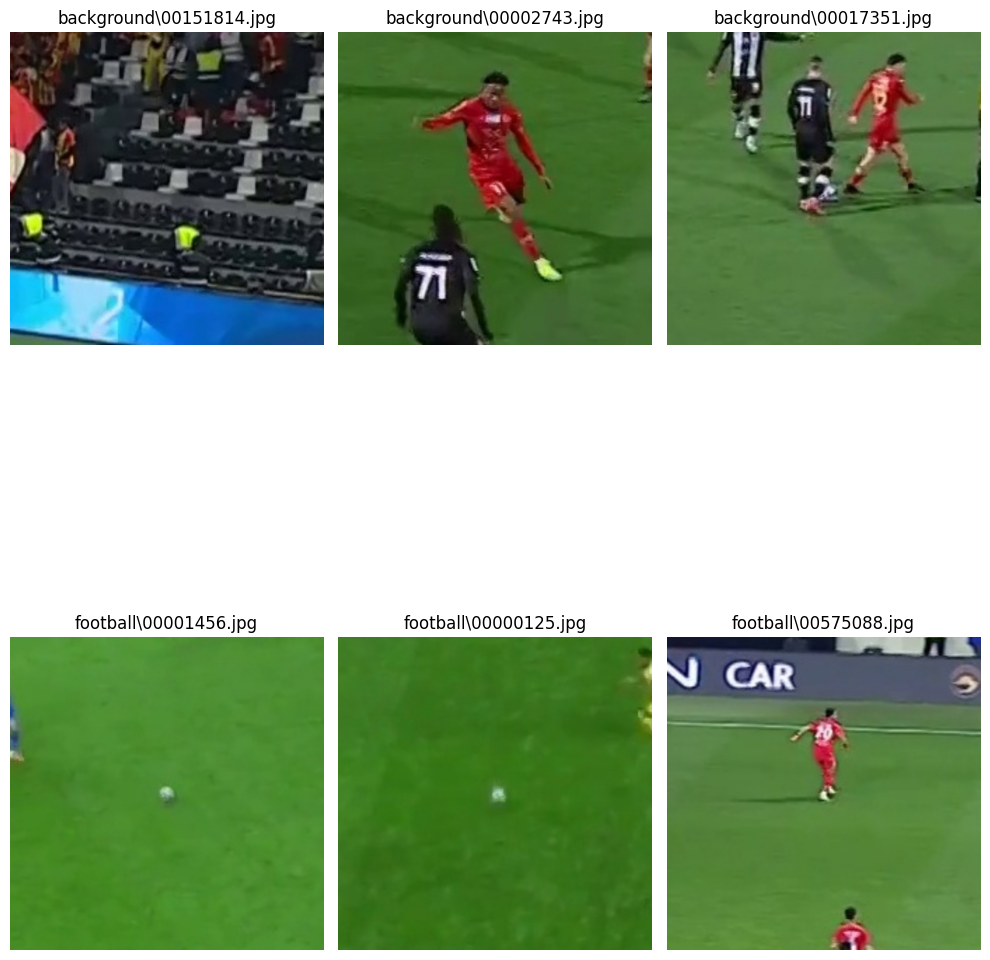

In [94]:
# Display a set of 3 random images each from the cleaned dataset

cleaned_fb_images = extract_file_names(save_footballs)
cleaned_bg_images = extract_file_names(save_backgrounds)

num_bg_images = len(cleaned_bg_images)
num_fb_images = len(cleaned_fb_images)

bg_images_temp = random.sample(cleaned_bg_images, 3)
fb_images_temp = random.sample(cleaned_fb_images, 3)

display_images(2, 3, [bg_images_temp, fb_images_temp])

plt.tight_layout()
plt.show()

In [95]:
# unload model and free up GPU memory
del model
torch.cuda.empty_cache()